In [1]:
import orbipy as op
import numpy as np
import pandas as pd
from numba.core.ir import Raise
from numba.np.arrayobj import np_array
from orbipy import plotter
from orbipy.correction import border_correction
from scipy.optimize import bisect

In [2]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1-model.L1) / 61.350

In [30]:
# =========================================================================

In [4]:
left = op.eventX(model.L1 - 4 * one_thousand_kms)
# right = op.eventX(model.L1 + 10 * one_thousand_kms)

points = []
dr = 3*one_thousand_kms
initial_state = model.get_zero_state()
initial_state[[0,2]] = [model.L1, 0]
points.append(initial_state[[0, 2]])

def zero_velocity_correction(correction, initial_state, previous_alpha_degrees):
    def find_alpha(alpha_degrees):
        state = model.get_zero_state().copy()
        x = initial_state[0] + np.cos(np.radians(alpha_degrees))*dr
        z = initial_state[2] + np.sin(np.radians(alpha_degrees))*dr
        state[[0,2]] = x, z
        v = correction.calc_dv(0, state)
        # print(v[4])
        return v[4]
        
    # print(initial_state)
    # print("border left", find_alpha(previous_alpha_degrees - 60))
    # print("border right", find_alpha(previous_alpha_degrees + 60))

    res = bisect(find_alpha, previous_alpha_degrees - 30, previous_alpha_degrees + 30, 
        xtol=1e-6, maxiter=100,
        full_output=True)
    
    target_alpha_degrees = res[0]
    print("== alpha", target_alpha_degrees)
    r = np.zeros_like(initial_state)
    x = np.cos(np.radians(target_alpha_degrees))*dr
    z = np.sin(np.radians(target_alpha_degrees))*dr
    r[[0, 2]] = x, z
    return r, target_alpha_degrees

In [ ]:
alpha = 90

for i in range(45):
    right = op.eventX(model.L1 + (4+i) * one_thousand_kms)
    correction = op.border_correction(model, op.y_direction(), left, right, maxt=7*np.pi)
    zero_velocity_point_correction, alpha = zero_velocity_correction(correction, initial_state, alpha)
    initial_state += zero_velocity_point_correction
    points.append(initial_state[[0, 2]])
    print(points[-1])
print("==== Finished ====")

In [93]:
zero_velocity_line = np.array(points)
print(zero_velocity_line)

[[0.83687856 0.        ]
 [0.83699613 0.00797573]
 [0.83734812 0.01594456]
 [0.83793236 0.02389973]
 [0.83874524 0.03183481]
 [0.83978176 0.03974377]
 [0.84103552 0.04762122]
 [0.8424988  0.05546245]
 [0.84416255 0.06326361]
 [0.8460165  0.07102177]
 [0.84804915 0.07873503]
 [0.85024788 0.08640261]
 [0.85259895 0.09402485]
 [0.8550876  0.10160329]
 [0.85769809 0.10914063]
 [0.86041376 0.11664071]
 [0.86321712 0.12410847]
 [0.86608989 0.13154979]
 [0.86901312 0.13897144]
 [0.87196729 0.14638082]
 [0.87493245 0.15378582]
 [0.87788837 0.1611945 ]
 [0.88081479 0.1686149 ]
 [0.88369161 0.17605466]
 [0.88649924 0.1835208 ]
 [0.88921872 0.1910195 ]
 [0.89179566 0.19856838]
 [0.89415056 0.20618944]
 [0.89635658 0.21385492]
 [0.8984027  0.22156462]
 [0.90028074 0.22931698]
 [0.90198468 0.23710946]
 [0.90351152 0.24493857]
 [0.90486038 0.25280029]
 [0.90603243 0.26069031]
 [0.90703049 0.26860422]
 [0.90785926 0.27653765]
 [0.90852418 0.28448649]
 [0.90903156 0.29244693]
 [0.90938802 0.30041556]


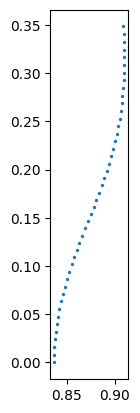

In [99]:
from matplotlib import pyplot as plt

plt.scatter(zero_velocity_line[:,0], zero_velocity_line[:,1], s=2)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
ax = plotter.plot_proj(df, centers={'x':model.L1})
plotter.plot_proj(ax=ax, centers={'x':model.L1}, plottables=[plotter.L1, plotter], colors='k',ls='',marker='o')

In [100]:
datatmp = np.array([
       [0.83687856, 0.        ],
       [0.83699613, 0.00797573],
       [0.83734812, 0.01594456],
       [0.83793236, 0.02389973],
       [0.83874524, 0.03183481],
       [0.83978176, 0.03974377],
       [0.84103552, 0.04762122],
       [0.8424988 , 0.05546245],
       [0.84416255, 0.06326361],
       [0.8460165 , 0.07102177],
       [0.84804915, 0.07873503],
       [0.85024788, 0.08640261],
       [0.85259895, 0.09402485],
       [0.8550876 , 0.10160329],
       [0.85769809, 0.10914063],
       [0.86041376, 0.11664071],
       [0.86321712, 0.12410846],
       [0.86608989, 0.13154979],
       [0.86901312, 0.13897143],
       [0.87196729, 0.14638082],
       [0.87493245, 0.15378581],
       [0.87785029, 0.16120958],
       [0.880549,   0.16871579],
       [0.88316644, 0.17625071]])
np.savetxt('zvl_2.txt',zero_velocity_line)
np.save('zvl_2',zero_velocity_line)

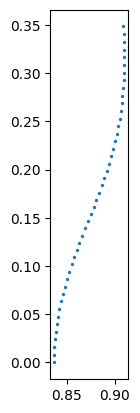

In [4]:
from matplotlib import pyplot as plt

data = np.load('data/contour_points/zvl/zvl_2.npy')
plt.scatter(data[:,0], data[:,1], s=2)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [5]:
# ==================================

In [6]:
def jacoby_constant(model, state):
    x, y, z, vx, vy, vz = state[:6]
    return x**2 + y**2 + 2*((1-model.mu) / np.sqrt((x + model.mu)**2 + y**2 + z**2) + model.mu/np.sqrt((x - 1 + model.mu)**2 + y**2 + z**2)) - (vx**2 + vy**2 + vz**2)

In [15]:
def calculate_next_point_with_same_jacoby_constant(correction, previous_state, cj, previous_alpha_degrees):
    def find_alpha(alpha_degrees):
        state = model.get_zero_state().copy()
        x = previous_state[0] + np.cos(np.radians(alpha_degrees))*dr
        z = previous_state[2] + np.sin(np.radians(alpha_degrees))*dr
        state[[0,2]] = x, z
        state[4] = previous_state[4]
        # print(state)
        velocity = correction.calc_dv(0, state)
        state += velocity
        cj_new = jacoby_constant(model, state)
        # print("cj:", cj, "cj_new:", cj_new, "state:", state[[0, 2, 4]])
        return cj - cj_new
        
    # print(find_alpha(previous_alpha_degrees-15))

    res = bisect(find_alpha, previous_alpha_degrees - 40, previous_alpha_degrees + 40, 
        xtol=1e-6, maxiter=100,
        full_output=True)
    
    target_alpha_degrees = res[0]
    print("cj = "+ str(cj) + "; alpha = " + str(target_alpha_degrees))
    r = model.get_zero_state().copy()
    x = previous_state[0] + np.cos(np.radians(target_alpha_degrees))*dr
    z = previous_state[2] + np.sin(np.radians(target_alpha_degrees))*dr
    r[[0, 2]] = x, z
    r += correction.calc_dv(0, r)
    return r, target_alpha_degrees

def calculate_contour_line_of_jakobi_constant(model, initial_state, alpha, points):
    Cj = jacoby_constant(model, initial_state)
    
    points.append(initial_state[[0, 2, 4]].tolist())
    
    left = op.eventX(model.L1 - 33 * one_thousand_kms)
    right = op.eventX(model.L1 + 53 * one_thousand_kms)

    while points[-1][1] > 0:
        print(left, right)
        correction = op.border_correction(model, op.y_direction(), left, right)
        try:
            next_point_with_same_jakoby_constant, alpha = calculate_next_point_with_same_jacoby_constant(correction, initial_state, Cj, alpha)
        except (RuntimeError, ValueError) as e:
            print(e, sep=' ')  
            print(f"next point from {points[-1]} failed!")
            break
        initial_state = next_point_with_same_jakoby_constant
        points.append(initial_state[[0, 2, 4]].tolist())
        print(points[-1])
    print("==== Finished ====")

In [9]:

dr = 2*one_thousand_kms
points = []

initial_state_points = np.array(np.meshgrid(np.arange(5, 46), [0, 180])).T.reshape(-1, 2).tolist()
print(initial_state_points)

for point in initial_state_points:
    alpha = point[1]
    initial_state = model.get_zero_state()
    initial_state[[0,2]] = data[point[0]][0], data[point[0]][1]
    
    new_points = []
    calculate_contour_line_of_jakobi_constant(model, initial_state, alpha, new_points)
    print(new_points)
    points.append(new_points)


[[5, 0], [5, 180], [6, 0], [6, 180], [7, 0], [7, 180], [8, 0], [8, 180], [9, 0], [9, 180], [10, 0], [10, 180], [11, 0], [11, 180], [12, 0], [12, 180], [13, 0], [13, 180], [14, 0], [14, 180], [15, 0], [15, 180], [16, 0], [16, 180], [17, 0], [17, 180], [18, 0], [18, 180], [19, 0], [19, 180], [20, 0], [20, 180], [21, 0], [21, 180], [22, 0], [22, 180], [23, 0], [23, 180], [24, 0], [24, 180], [25, 0], [25, 180], [26, 0], [26, 180], [27, 0], [27, 180], [28, 0], [28, 180], [29, 0], [29, 180], [30, 0], [30, 180], [31, 0], [31, 180], [32, 0], [32, 180], [33, 0], [33, 180], [34, 0], [34, 180], [35, 0], [35, 180], [36, 0], [36, 180], [37, 0], [37, 180], [38, 0], [38, 180], [39, 0], [39, 180], [40, 0], [40, 180], [41, 0], [41, 180], [42, 0], [42, 180], [43, 0], [43, 180], [44, 0], [44, 180], [45, 0], [45, 180]]
eventX:[val]np.float64(0.7491359754271466) [dir]0 [trm]True [acc]True [cnt]-1 eventX:[val]np.float64(0.9777984673536478) [dir]0 [trm]True [acc]True [cnt]-1
cj = 3.1803714680257813; alpha = 

RuntimeError: Borders unreachable

(46, 3)
[[0.83687856 0.         0.        ]
 [0.83699613 0.00797573 0.        ]
 [0.83734812 0.01594456 0.        ]
 [0.83793236 0.02389973 0.        ]
 [0.83874524 0.03183481 0.        ]
 [0.83978176 0.03974377 0.        ]
 [0.84103552 0.04762122 0.        ]
 [0.8424988  0.05546245 0.        ]
 [0.84416255 0.06326361 0.        ]
 [0.8460165  0.07102177 0.        ]
 [0.84804915 0.07873503 0.        ]
 [0.85024788 0.08640261 0.        ]
 [0.85259895 0.09402485 0.        ]
 [0.8550876  0.10160329 0.        ]
 [0.85769809 0.10914063 0.        ]
 [0.86041376 0.11664071 0.        ]
 [0.86321712 0.12410847 0.        ]
 [0.86608989 0.13154979 0.        ]
 [0.86901312 0.13897144 0.        ]
 [0.87196729 0.14638082 0.        ]
 [0.87493245 0.15378582 0.        ]
 [0.87788837 0.1611945  0.        ]
 [0.88081479 0.1686149  0.        ]
 [0.88369161 0.17605466 0.        ]
 [0.88649924 0.1835208  0.        ]
 [0.88921872 0.1910195  0.        ]
 [0.89179566 0.19856838 0.        ]
 [0.89415056 0.20618

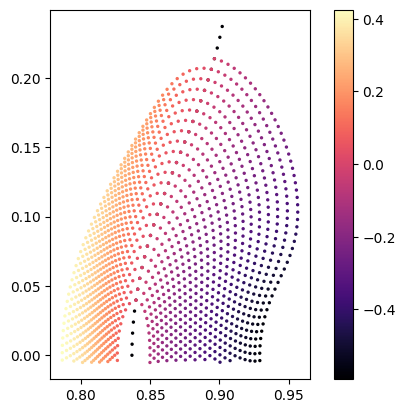

In [12]:
from matplotlib import pyplot as plt

data = np.load('data/contour_points/zvl/zvl_2.npy')
data = np.c_[data, np.zeros(len(data))]
print(data.shape)

data_points = []
for line in points:
    for point in line:
        data_points.append(point)
        
data_points = np.array(data_points)

print(data)
plt.scatter(data[:32,0], data[:32,1], c=data[:32,2], cmap='magma', s=2)
plt.scatter(data_points[:,0], data_points[:,1], c=data_points[:,2], cmap='magma', s=2)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [13]:
import pickle
with open("data/contour_points/contour_points_data_4_points.pickle", 'wb') as handle:
    pickle.dump(points, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
data = np.load('data/contour_points/zvl/zvl_2.npy')

initial_state = model.get_zero_state()
initial_state[[0,2]] = data[30][0], data[30][1]

new_points = []
alpha = 180
calculate_contour_line_of_jakobi_constant(model, initial_state, alpha, new_points)
print(new_points)

eventX:[val]np.float64(0.7491359754271466) [dir]0 [trm]True [acc]True [cnt]-1 eventX:[val]np.float64(0.9777984673536478) [dir]0 [trm]True [acc]True [cnt]-1
cj = 3.0095395926277466; alpha = 173.25456082820892
[0.8949998189173971, 0.2299415968761828, 0.02573816960147903]
eventX:[val]np.float64(0.7491359754271466) [dir]0 [trm]True [acc]True [cnt]-1 eventX:[val]np.float64(0.9777984673536478) [dir]0 [trm]True [acc]True [cnt]-1
cj = 3.0095395926277466; alpha = 184.99560356140137
[0.8897022865765428, 0.2294785324523391, 0.04983610418347703]
eventX:[val]np.float64(0.7491359754271466) [dir]0 [trm]True [acc]True [cnt]-1 eventX:[val]np.float64(0.9777984673536478) [dir]0 [trm]True [acc]True [cnt]-1
cj = 3.0095395926277466; alpha = 198.22325766086578
[0.8846512640659563, 0.22781556848382536, 0.07411809690564607]
eventX:[val]np.float64(0.7491359754271466) [dir]0 [trm]True [acc]True [cnt]-1 eventX:[val]np.float64(0.9777984673536478) [dir]0 [trm]True [acc]True [cnt]-1
cj = 3.0095395926277466; alpha = 

capi_return is NULL
Call-back cb_solout_in___user__routines failed.


KeyboardInterrupt: 

In [70]:
with open(r"data/contour_points/contour_points_data_5_points.pickle", "rb") as input_file:
    data = pickle.load(input_file)

data.append(new_points)

with open("data/contour_points/contour_points_data_5_points.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

[[ 0.83978176  0.03974377  0.        ]
 [ 0.84400702  0.03651493 -0.03653769]
 [ 0.84621314  0.03167641 -0.0579208 ]
 ...
 [ 0.86437034  0.20391295  0.18204073]
 [ 0.86190494  0.19920126  0.23500806]
 [ 0.86127816  0.19392059  0.17046892]]


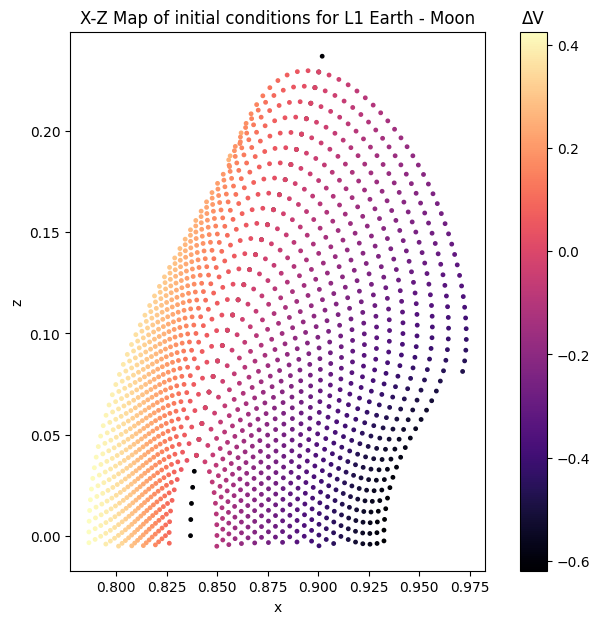

In [71]:
from matplotlib import pyplot as plt
import pickle

data_zvl = np.load('data/contour_points/zvl/zvl_2.npy')
data_zvl = np.c_[data_zvl, np.zeros(len(data_zvl))]

with open(r"data/contour_points/contour_points_data_5_points.pickle", "rb") as input_file:
    data = pickle.load(input_file)
    
data_points = []
for line in data:
    for point in line:
        data_points.append(point)
        
data_points = np.array(data_points)

print(data_points)
plt.figure(figsize=(9, 7))
plt.scatter(data_zvl[:32,0], data_zvl[:32,1], c=data_zvl[:32,2], cmap='magma', s=6)
plt.scatter(data_points[:,0], data_points[:,1], c=data_points[:,2], cmap='magma', s=6)

plt.title('X-Z Map of initial conditions for L1 Earth - Moon')
plt.xlabel('x')
plt.ylabel('z')

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
clb = plt.colorbar()
clb.ax.set_title('ΔV')
plt.show()

In [61]:
one_thousand_kms

np.float64(0.002658866185191875)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


array([<Axes: xlabel='x, ${\\cdot}10^3$ km', ylabel='y, ${\\cdot}10^3$ km'>,
       <Axes: xlabel='x, ${\\cdot}10^3$ km', ylabel='z, ${\\cdot}10^3$ km'>,
       <Axes: xlabel='y, ${\\cdot}10^3$ km', ylabel='z, ${\\cdot}10^3$ km'>],
      dtype=object)

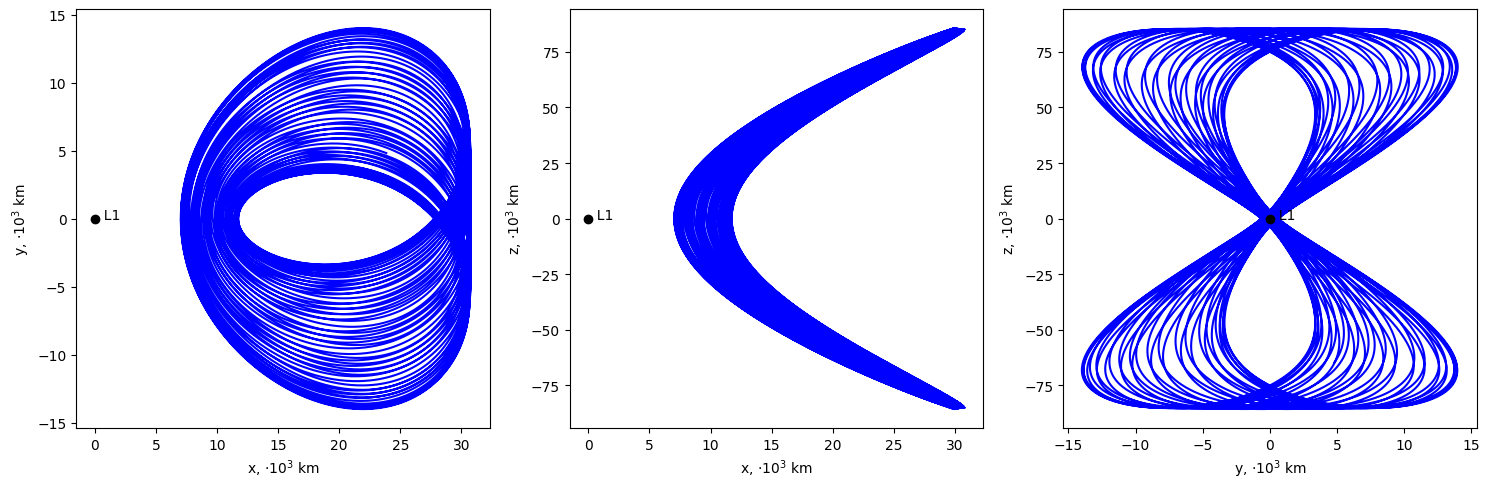

In [19]:
left = op.eventX(model.L1 - 4 * one_thousand_kms)
right = op.eventX(model.L1 + 40 * one_thousand_kms)

first_correction = op.border_correction(model, op.y_direction(), [left], [right])
correction = op.border_correction(model, op.unstable_direction(model), [left], [right])
impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=2*np.pi)

s0 = model.get_zero_state()
# s0[0] = 0.97137238
# s0[2] = 0.12081594

s0[0] = 9.148615535811789323e-01
s0[2] = 2.229407089626999627e-01


df = impulse_correction.prop(0.0, s0, N=20)

plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
ax = plotter.plot_proj(df, centers={'x':model.L1})
plotter.plot_proj(ax=ax, centers={'x':model.L1}, plottables=[plotter.L1], colors='k',ls='',marker='o')

[ 0.84438705  0.          0.04240264  0.         -0.03257659  0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.        ]


array([<Axes: xlabel='x, ${\\cdot}10^3$ km', ylabel='y, ${\\cdot}10^3$ km'>,
       <Axes: xlabel='x, ${\\cdot}10^3$ km', ylabel='z, ${\\cdot}10^3$ km'>,
       <Axes: xlabel='y, ${\\cdot}10^3$ km', ylabel='z, ${\\cdot}10^3$ km'>],
      dtype=object)

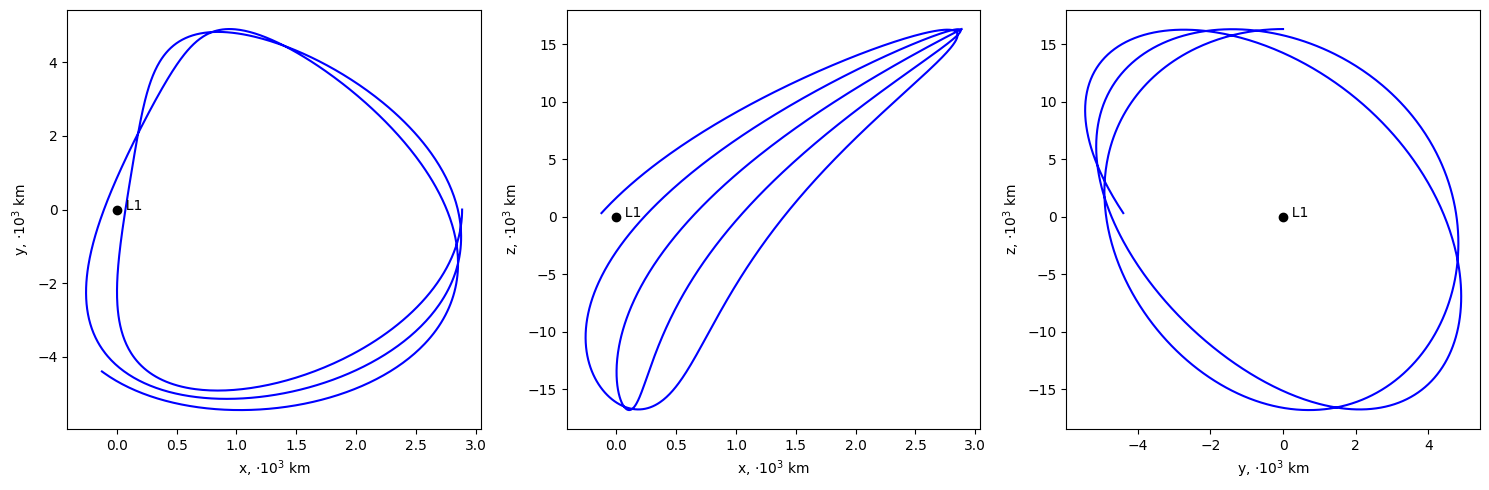

In [18]:
left = op.eventX(model.L1 - 10 * one_thousand_kms)
right = op.eventX(model.L1 + 30 * one_thousand_kms)

# first_correction = op.border_correction(model, op.y_direction(), [left], [right])
# correction = op.border_correction(model, op.unstable_direction(model), [left], [right])
# impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=2*np.pi)
correction = op.border_correction(model, op.y_direction(), [left], [right])

s0 = model.get_zero_state()
s0[0] = 0.84438705
s0[2] = 0.04240264

# s0[0] = 9.660916345280373685e-01 
# s0[2] = 1.441413425661594305e-01
# s0[4] = 0.000012

s0 += correction.calc_dv(0, s0)

print(s0)

df = model.prop(s0, 0, 2*np.pi)

plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
ax = plotter.plot_proj(df, centers={'x':model.L1})
plotter.plot_proj(ax=ax, centers={'x':model.L1}, plottables=[plotter.L1], colors='k',ls='',marker='o')



In [95]:
right

eventX:[val]np.float64(1.0495878543538284) [dir]0 [trm]True [acc]True [cnt]-1

In [92]:
left

eventX:[val]np.float64(0.9166445450942347) [dir]0 [trm]True [acc]True [cnt]-1